In [1]:
import pandas as pd
import numpy as np

import datetime
import os, sys
import matplotlib.pyplot as plt

from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import tensorflow as tf
import copy
import matplotlib.patches as mpatches
import time
from pandas import concat
from pandas import DataFrame

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(7)
from sklearn.metrics import r2_score
from Column_settings import *
from W_settings import *
from pollution_plots import *

import matplotlib.patches as mpatches

/home/qdesmedt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
folder = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

batch_sizes = []
times_test = []
times_train = []
RMSES = []


In [5]:
def plot_lstm_vs_time(batch_sizes, times_test, times_train):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_title('LSTM Seq2Seq batch sizes vs. Runtime', fontsize=16)
    ax.set_ylabel('Time in seconds', fontsize=16)
    ax.set_xlabel('Batch size', fontsize=16)
    ax.plot(batch_sizes, times_train, label='Train time', marker='x')
    ax.plot(batch_sizes, times_test, label='Test time', marker='x')
    ax.legend()
    plt.show()
    fig.savefig('./SVR/temp_saluel')


In [6]:
def plot_lstm_vs_rmse(hidden_dims, rmses):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_title('LSTM Seq2Seq Hidden Dim vs. RMSE', fontsize=16)
    ax.set_ylabel('RMSE', fontsize=16)
    ax.set_xlabel('# of hidden dimensions', fontsize=16)
    ax.plot(hidden_dims, rmses, marker='x')
    plt.axvline(x=30, color='red', linestyle='dashed', linewidth=1)
    plt.show()
    fig.savefig('./SVR/dimension_saluel')


In [25]:
def plot_test(final_preds_expand, test_y_expand, str_legend, folder):
    """
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title("Test Predictions vs. Actual For Last Year")
    ax.plot(final_preds_expand, color = 'red', label = 'predicted')
    ax.plot(test_y_expand, color = 'green', label = 'actual')
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig('plt_test.png')
    """
    text = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    fig_verify = plt.figure()
    plt.plot(final_preds_expand, color="blue")
    plt.plot(test_y_expand, color="orange")
    plt.title('Seq2Sea Train :' + begin_date + ' - ' + test_date  + '\nTest :' + begin_test + ' - ' + final_date)
    plt.ylabel('value')
    plt.xlabel('row')
    #str_legend = 'station: '+ str(station) + '\nR2 = ' + str(r2_score(test_y_expand, final_preds_expand)) + '\nMSE = ' + str(mse.item())
    #str_data = 'Train :' + begin_date + ' - ' + test_date  + '\nTest :' + begin_test + ' - ' + final_date
    first_legend = plt.legend(['predicted', 'actual data'] , loc='upper left')
    dates_legend = plt.legend([str_legend], loc='upper right')

    #mesures_legend = plt.legend([str_legend], loc='upper right')

    ax = plt.gca().add_artist(first_legend)

    #ay = plt.gca().add_artist(mesures_legend)


    #plt.legend([AnyObject()], [str_legend],
     #          handler_map={AnyObject: AnyObjectHandler()})

    plt.show()
    path_model_regression_verify = "./Seq2seq_juillet/"+ folder + "/Seq2seq_lilleSeq2seq_lille" + text + ".png"

    fig_verify.savefig(path_model_regression_verify)


In [26]:
class AnyObject(object):
    pass



In [27]:
class AnyObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle([x0, y0], width, height, facecolor='red',
                                   edgecolor='black', hatch='xx', lw=3,
                                   transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        return patch


In [28]:
np.random.seed(7)


In [29]:
#changed all , by . in cvs files

def write_results(text):
    #file = open("results.txt", "w")

    now = datetime.datetime.now()

    with open("results.txt", "a") as file:
        text = now.strftime("%Y-%m-%d %H:%M:%S") + ": " + "\n" + text + "\n" + "\n"
        file.write(text)


In [30]:
salouel_raw_data = pd.read_csv("Moyennes_J_salouel_2005_2015.csv", header=None, sep=';', decimal=',')


creil_raw_data = pd.read_csv("Moyennes_J_creil_2005_2015.csv", header=None, sep=';', decimal=',')

cols = ['Date', 'NO2', 'O3', 'PM10', 'RR', 'TN', 'TX', 'TM',
                     'PMERM', 'FFM', 'DXY', 'UM', 'GLOT']

roth_raw_data = pd.read_csv("Moyennes_J_roth_2005_2015.csv", header=None, sep=';', decimal=',')


In [31]:
def preprocessing_data(df):
    df = df.iloc[1:]
    df.columns = cols
    df = df.drop(["Date", 'NO2', 'O3'], axis=1)
    df = df.astype(float)
    return df


In [32]:
salouel_data = preprocessing_data(salouel_raw_data)
creil_data = preprocessing_data(creil_raw_data)
roth_data = preprocessing_data(roth_raw_data)


In [33]:
def get_season(dt):
    # it returnts string
    #print('type of dt:' + str(type(dt)))
    #print(dt)
    dt = dt.date()
    if (dt.month < 3):
        return 'H'
    elif (dt.month < 6):
        return 'P'
    elif (dt.month < 9):
        return "E"
    elif (dt.month < 12):
        return "A"
    else:
        return "H"


In [34]:
separation_date = '31/12/2010'
begin_test = '01/01/2015'
test_date = '31/12/2013'
begin_date = '01/01/2005'
final_date = '31/12/2015'


In [35]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    #print("cols:")
    #print(cols)
    agg = concat(cols, axis=1)

    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [36]:
def prepare_data(df_temp, keep_season=False, keep_wind=False):

    train_data = df_temp[df_temp['Date'] < test_date].drop(["Date"], axis=1).dropna(axis=0, how="any")
    test_data = df_temp[df_temp['Date'] > test_date].drop(["Date"], axis=1).dropna(axis=0, how="any")

    season_train = train_data['Season']
    season_test = test_data['Season']

    train_data = train_data.drop("Season", axis=1)
    test_data = test_data.drop("Season", axis=1)

    vent_train = train_data["vent"]
    vent_test = test_data["vent"]

    train_data = train_data.drop("vent", axis=1)
    test_data = test_data.drop("vent", axis=1)

    """
    for col in salouel_data.columns:
        train_data[col] = train_data[col].apply(scale_transformer, args=(settings_array[col],))

    for col in test_data.columns:
        test_data[col] = test_data[col].apply(scale_transformer, args=(settings_array[col],))
    """
    if(keep_season):
        train_data["Season"] = season_train
        test_data["Season"] = season_test

    if(keep_wind):
        train_data["vent"] = vent_train
        test_data["vent"] = vent_test

    train_data = pd.get_dummies(train_data)
    test_data = pd.get_dummies(test_data)
    #print(test_data.info())
    train_data.to_csv('./data/train.csv')

    test_data.to_csv('./data/test.csv')

    print("Dataframes saved...")
    return train_data, test_data


In [37]:
def clean_data(array_raw_data, cut):
    global begin_date
    # concat is first
    conc = True
    df = array_raw_data.iloc[1:]
    df.columns = cols
    df_temp = df.drop(["Date", 'NO2', 'O3'], axis=1)
    df_temp = df_temp.astype(float)
    df_temp["Date"] = pd.to_datetime(df["Date"])
    if cut == True:
        df_temp = df_temp[df_temp['Date'] > separation_date]
        begin_date = '01/01/2010'
    else:
        begin_date = '01/01/2005'
    # df_temp["Date"] = pd.to_datetime(df["Date"])
    df_temp['Season'] = df_temp["Date"].apply(get_season)
    df_temp['vent'] = df_temp['DXY'].apply(get_dir)

    return df_temp


In [38]:
n_past = 90
n_future = 10


In [39]:
def gen_sequence(df, n_future):
    X_seq = []
    for i in range(n_past, len(df) - n_future + 1):
        X_seq.append(df.iloc[i - n_past : i, :].values)
    return X_seq


In [40]:
def test_station(data, station, cut):
    global folder, os
    print("Entered in Function " + station)
    #text = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if not (os.path.isdir(folder)):
        os.mkdir(folder)
    df_temp = clean_data(data, cut)

    # Pollution plots go here

   # display_plot(df_temp)

    train_data, test_data = prepare_data(df_temp, True, True)


    #print(test_data.head())


    #X_train = train_data.loc[:, ['PM10', 'RR', 'TN', 'TX', 'TM', 'PMERM', 'FFM', 'DXY', 'UM', 'GLOT']].values.copy()
    #X_test = test_data.loc[:, ['PM10', 'RR', 'TN', 'TX', 'TM', 'PMERM', 'FFM', 'DXY', 'UM', 'GLOT']].values.copy()

    #X_train = train_data.loc[:, ['PM10', 'RR', 'TN', 'TX', 'TM', 'PMERM', 'FFM', 'UM', 'GLOT', 'vent_E', 'vent_SO','vent_N', 'vent_NE', 'vent_NO', 'vent_O', 'vent_S', 'vent_SE']].values.copy()
    #X_test = test_data.loc[:, ['PM10', 'RR', 'TN', 'TX', 'TM', 'PMERM', 'FFM', 'UM', 'GLOT', 'vent_E', 'vent_SO','vent_N', 'vent_NE', 'vent_NO', 'vent_O', 'vent_S', 'vent_SE']].values.copy()

    #X_train = train_data.loc[:, ['PM10', 'RR', 'TN', 'TX', 'TM', 'PMERM', 'FFM', 'UM', 'GLOT']].values.copy()
    #X_test = test_data.loc[:, ['PM10', 'RR', 'TN', 'TX', 'TM', 'PMERM', 'FFM', 'UM', 'GLOT']].values.copy()


    X_train = train_data.loc[:, ['PM10', 'RR', 'TN', 'TX', 'TM', 'PMERM', 'FFM', 'UM', 'GLOT', 'Season_A', 'Season_E', 'Season_H', 'Season_P']].values.copy()
    X_test = test_data.loc[:, ['PM10', 'RR', 'TN', 'TX', 'TM', 'PMERM', 'FFM', 'UM', 'GLOT', 'Season_A', 'Season_E', 'Season_H', 'Season_P']].values.copy()

    reframed_train = series_to_supervised(X_train, n_in=1)
    reframed_test = series_to_supervised(X_test, n_in=1)

    X_test = np.copy(reframed_test)
    X_train = np.copy(reframed_train)

    print("X test")
    print(X_test.shape)
    y_train = train_data['PM10'].values.copy().reshape(-1, 1)
    #print("shape:")
    #print(y_train.shape[1])
    y_test = test_data['PM10'].values.copy().reshape(-1, 1)

    #print(X_train.shape)  #    (3436, 10)

    #print(y_train.shape)  #    (3436, 1)

    #print(X_train.shape[1])

    for i in range(X_train.shape[1]):
        temp_mean = X_train[:, i].mean()
        temp_std = X_train[:, i].std()
        X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
        X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std


    ## z-score transform y
    y_mean = y_train.mean()
    y_std = y_train.std()
    y_train = (y_train - y_mean) / y_std
    y_test = (y_test - y_mean) / y_std

    input_seq_len = 30
    output_seq_len = 1

    def generate_train_samples(x=X_train, y=y_train, batch_size=16, input_seq_len=input_seq_len,
                               output_seq_len=output_seq_len):
        total_start_points = len(x) - input_seq_len - output_seq_len
        start_x_idx = np.random.choice(range(total_start_points), batch_size, replace=False)

        input_batch_idxs = [list(range(i, i + input_seq_len)) for i in start_x_idx]
        input_seq = np.take(x, input_batch_idxs, axis=0)

        output_batch_idxs = [list(range(i + input_seq_len, i + input_seq_len + output_seq_len)) for i in start_x_idx]
        output_seq = np.take(y, output_batch_idxs, axis=0)

        return input_seq, output_seq  # in shape: (batch_size, time_steps, feature_dim)

    def generate_test_samples(x=X_test, y=y_test, input_seq_len=input_seq_len, output_seq_len=output_seq_len):
        total_samples = x.shape[0]

        input_batch_idxs = [list(range(i, i + input_seq_len)) for i in
                            range((total_samples - input_seq_len - output_seq_len))]
        input_seq = np.take(x, input_batch_idxs, axis=0)

        output_batch_idxs = [list(range(i + input_seq_len, i + input_seq_len + output_seq_len)) for i in
                             range((total_samples - input_seq_len - output_seq_len))]
        output_seq = np.take(y, output_batch_idxs, axis=0)

        return input_seq, output_seq

    x, y = generate_train_samples()
    #print(x.shape, y.shape)

    test_x, test_y = generate_test_samples()
    #print(test_x.shape, test_y.shape)

    from tensorflow.contrib import rnn
    from tensorflow.python.ops import variable_scope
    from tensorflow.python.framework import dtypes
    import tensorflow as tf
    import copy
    import os

    ## Parameters
    learning_rate = 0.02
    lambda_l2_reg = 0.003

    ## Network Parameters
    # length of input signals
    input_seq_len = input_seq_len
    # length of output signals
    output_seq_len = output_seq_len
    # size of LSTM Cell
    hidden_dim = 20
    # num of input signals
    input_dim = X_train.shape[1]
    # num of output signals
    output_dim = y_train.shape[1]
    # num of stacked lstm layers
    num_stacked_layers = 2
    # gradient clipping - to avoid gradient exploding
    GRADIENT_CLIPPING = 2.5

    def build_graph(feed_previous=False):
        print("in build_graph " + station)

        tf.reset_default_graph()

        global_step = tf.Variable(
            initial_value=0,
            name="global_step",
            trainable=False,
            collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])

        weights = {
            'out': tf.get_variable('Weights_out', \
                                   shape=[hidden_dim, output_dim], \
                                   dtype=tf.float32, \
                                   initializer=tf.truncated_normal_initializer()),
        }
        biases = {
            'out': tf.get_variable('Biases_out', \
                                   shape=[output_dim], \
                                   dtype=tf.float32, \
                                   initializer=tf.constant_initializer(0.)),
        }

        with tf.variable_scope('Seq2seq'):
            # Encoder: inputs
            enc_inp = [
                tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
                for t in range(input_seq_len)
            ]

            # Decoder: target outputs
            target_seq = [
                tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
                for t in range(output_seq_len)
            ]

            # Give a "GO" token to the decoder.
            # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the
            # first element will be fed as decoder input which is then 'un-guided'
            dec_inp = [tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO")] + target_seq[:-1]

            with tf.variable_scope('LSTMCell'):
                cells = []
                for i in range(num_stacked_layers):
                    with tf.variable_scope('RNN_{}'.format(i)):
                        cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
                cell = tf.contrib.rnn.MultiRNNCell(cells)

            def _rnn_decoder(decoder_inputs,
                             initial_state,
                             cell,
                             loop_function=None,
                             scope=None):
                """RNN decoder for the sequence-to-sequence model.
                Args:
                  decoder_inputs: A list of 2D Tensors [batch_size x input_size].
                  initial_state: 2D Tensor with shape [batch_size x cell.state_size].
                  cell: rnn_cell.RNNCell defining the cell function and size.
                  loop_function: If not None, this function will be applied to the i-th output
                    in order to generate the i+1-st input, and decoder_inputs will be ignored,
                    except for the first element ("GO" symbol). This can be used for decoding,
                    but also for training to emulate http://arxiv.org/abs/1506.03099.
                    Signature -- loop_function(prev, i) = next
                      * prev is a 2D Tensor of shape [batch_size x output_size],
                      * i is an integer, the step number (when advanced control is needed),
                      * next is a 2D Tensor of shape [batch_size x input_size].
                  scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
                Returns:
                  A tuple of the form (outputs, state), where:
                    outputs: A list of the same length as decoder_inputs of 2D Tensors with
                      shape [batch_size x output_size] containing generated outputs.
                    state: The state of each cell at the final time-step.
                      It is a 2D Tensor of shape [batch_size x cell.state_size].
                      (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                       states can be the same. They are different for LSTM cells though.)
                """
                with variable_scope.variable_scope(scope or "rnn_decoder"):
                    state = initial_state
                    outputs = []
                    prev = None
                    for i, inp in enumerate(decoder_inputs):
                        if loop_function is not None and prev is not None:
                            with variable_scope.variable_scope("loop_function", reuse=True):
                                inp = loop_function(prev, i)
                        if i > 0:
                            variable_scope.get_variable_scope().reuse_variables()
                        output, state = cell(inp, state)
                        outputs.append(output)
                        if loop_function is not None:
                            prev = output
                return outputs, state

            def _basic_rnn_seq2seq(encoder_inputs,
                                   decoder_inputs,
                                   cell,
                                   feed_previous,
                                   dtype=dtypes.float32,
                                   scope=None):
                """Basic RNN sequence-to-sequence model.
                This model first runs an RNN to encode encoder_inputs into a state vector,
                then runs decoder, initialized with the last encoder state, on decoder_inputs.
                Encoder and decoder use the same RNN cell type, but don't share parameters.
                Args:
                  encoder_inputs: A list of 2D Tensors [batch_size x input_size].
                  decoder_inputs: A list of 2D Tensors [batch_size x input_size].
                  feed_previous: Boolean; if True, only the first of decoder_inputs will be
                    used (the "GO" symbol), all other inputs will be generated by the previous
                    decoder output using _loop_function below. If False, decoder_inputs are used
                    as given (the standard decoder case).
                  dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
                  scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
                Returns:
                  A tuple of the form (outputs, state), where:
                    outputs: A list of the same length as decoder_inputs of 2D Tensors with
                      shape [batch_size x output_size] containing the generated outputs.
                    state: The state of each decoder cell in the final time-step.
                      It is a 2D Tensor of shape [batch_size x cell.state_size].
                """
                with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
                    enc_cell = copy.deepcopy(cell)
                    _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
                    if feed_previous:
                        return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
                    else:
                        return _rnn_decoder(decoder_inputs, enc_state, cell)

            def _loop_function(prev, _):
                '''Naive implementation of loop function for _rnn_decoder. Transform prev from
                dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
                used as decoder input of next time step '''
                return tf.matmul(prev, weights['out']) + biases['out']

            dec_outputs, dec_memory = _basic_rnn_seq2seq(
                enc_inp,
                dec_inp,
                cell,
                feed_previous=feed_previous
            )

            reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]

        # Training loss and optimizer
        with tf.variable_scope('Loss'):
            # L2 loss
            output_loss = 0
            for _y, _Y in zip(reshaped_outputs, target_seq):
                output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

            # L2 regularization for weights and biases
            reg_loss = 0
            for tf_var in tf.trainable_variables():
                if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                    reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

            loss = output_loss + lambda_l2_reg * reg_loss

        with tf.variable_scope('Optimizer'):
            optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)

        saver = tf.train.Saver

        return dict(
            enc_inp=enc_inp,
            target_seq=target_seq,
            train_op=optimizer,
            loss=loss,
            saver=saver,
            reshaped_outputs=reshaped_outputs,
        )

    total_iteractions = 180
    batch_size = 16
    KEEP_RATE = 0.5
    train_losses = []
    val_losses = []

    x = np.linspace(0, 40, 130)
    train_data_x = x[:110]

    rnn_model = build_graph(feed_previous=False)

    saver = tf.train.Saver()
    start_train = time.time()
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)

        print("Training losses: ")
        for i in range(total_iteractions):
            batch_input, batch_output = generate_train_samples(batch_size=batch_size)

            feed_dict = {rnn_model['enc_inp'][t]: batch_input[:, t] for t in range(input_seq_len)}
            feed_dict.update({rnn_model['target_seq'][t]: batch_output[:, t] for t in range(output_seq_len)})
            _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)


        temp_saver = rnn_model['saver']()
        sous_chemin = './Seq2seq_juillet/' + folder + "/"

        save_path = temp_saver.save(sess, os.path.join(sous_chemin, 'mv_ts_pollution_case'))

    print("Checkpoint saved at: ", save_path)

    end_train = time.time()

    print('Time taken to train is {} minutes'.format((end_train - start_train) / 60))
    print('Time in seconds is: {}'.format(end_train - start_train))

    train_time = end_train - start_train

    rnn_model = build_graph(feed_previous=True)

    start_test = time.time()

    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        sous_chemin = './Seq2seq_juillet/' + folder + "/"
        saver = rnn_model['saver']().restore(sess, os.path.join(sous_chemin, 'mv_ts_pollution_case'))

        feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)}  # batch prediction
        feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in
                          range(output_seq_len)})
        final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
        #print("final pred:")
        #print(len(final_preds))
        final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
        final_preds = np.concatenate(final_preds, axis=1)

        #print("final pred transformated:")
        #print(final_preds.shape)

        print("Test mse is: ", np.mean((final_preds - test_y) ** 2))

    # Unscale the predictions
    # make into one array
    end_test = time.time()

    print('Time taken is: {} minutes.'.format((end_test - start_test) / 60))
    print('Time in seconds is: {}'.format(end_test - start_test))

    test_time = end_test - start_test

    dim1, dim2 = final_preds.shape[0], final_preds.shape[1]

    preds_flattened = final_preds.reshape(dim1 * dim2, 1)

    unscaled_yhat = pd.DataFrame(preds_flattened, columns=['PM10']).apply(lambda x: (x * y_std) + y_mean)

    yhat_inv = unscaled_yhat.values

    test_y_flattened = test_y.reshape(dim1 * dim2, 1)

    unscaled_y = pd.DataFrame(test_y_flattened, columns=['PM10']).apply(lambda x: (x * y_std) + y_mean)

    y_inv = unscaled_y.values

    pd.concat((unscaled_y, unscaled_yhat), axis=1)

    # Calculate RMSE and Plot
#    print("######")
#    print(yhat_inv)
#    print("######")


    mse = np.mean((yhat_inv - y_inv) ** 2)
    print(mse)

    rmse = np.sqrt(mse)
    print(rmse)
    str_legend = 'station: '+ str(station) + '\nR2 = ' + str(r2_score(y_inv, yhat_inv)) + '\nMSE = ' + str(mse.item()) + '\nRMSE' + str(rmse)

    plot_test(y_inv, yhat_inv, str_legend, folder)
#    print("######")
#    print(unscaled_y.values)
#    print("######")

    #plot_test(unscaled_yhat.values, unscaled_y.values)

    print('Root Mean Squared Error: {:.4f}'.format(rmse))

    # Calculate R^2 (regression score function)
    test_R2 = r2_score(y_inv, yhat_inv)
    print('Variance score: {:2f}'.format(r2_score(y_inv, yhat_inv)))
    #times_test.append(test_time)
    #times_train.append(train_time)
    RMSES.append(rmse)
    res = "RMSE: " + str(rmse) + "\nRMSE: " + "\nR2: " + str(test_R2)
    write_results(res)

    if os.path.isfile("./regression_model_merged.h5"):
        os.remove("./regression_model_merged.h5")


In [41]:
dict_data = {'salouel': salouel_raw_data, 'roth': roth_raw_data, 'creil': creil_raw_data}


Entered in Function salouel
Dataframes saved...
X test
(677, 26)
in build_graph salouel
Training losses: 
Checkpoint saved at:  ./Seq2seq_juillet/2018-07-16 15:52:14/mv_ts_pollution_case
Time taken to train is 0.07076772054036458 minutes
Time in seconds is: 4.246063232421875
in build_graph salouel
INFO:tensorflow:Restoring parameters from ./Seq2seq_juillet/2018-07-16 15:52:14/mv_ts_pollution_case
Test mse is:  0.02389481996440461
Time taken is: 0.008286861578623454 minutes.
Time in seconds is: 0.4972116947174072
4.772570307547361
2.184621319027021


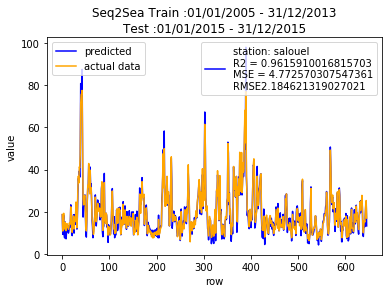

Root Mean Squared Error: 2.1846
Variance score: 0.961591
--------------------
Entered in Function roth
Dataframes saved...
X test
(679, 26)
in build_graph roth
Training losses: 
Checkpoint saved at:  ./Seq2seq_juillet/2018-07-16 15:52:14/mv_ts_pollution_case
Time taken to train is 0.06935619513193766 minutes
Time in seconds is: 4.16137170791626
in build_graph roth
INFO:tensorflow:Restoring parameters from ./Seq2seq_juillet/2018-07-16 15:52:14/mv_ts_pollution_case
Test mse is:  0.045374700098040704
Time taken is: 0.009276382128397624 minutes.
Time in seconds is: 0.5565829277038574
8.716936079795493
2.9524457793150907


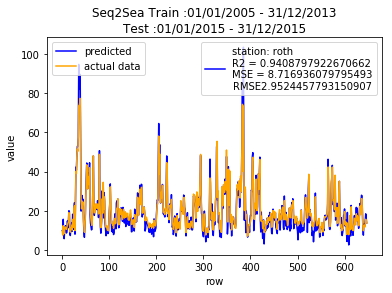

Root Mean Squared Error: 2.9524
Variance score: 0.940880
--------------------
Entered in Function creil
Dataframes saved...
X test
(659, 26)
in build_graph creil
Training losses: 
Checkpoint saved at:  ./Seq2seq_juillet/2018-07-16 15:52:14/mv_ts_pollution_case
Time taken to train is 0.06534831126530966 minutes
Time in seconds is: 3.920898675918579
in build_graph creil
INFO:tensorflow:Restoring parameters from ./Seq2seq_juillet/2018-07-16 15:52:14/mv_ts_pollution_case
Test mse is:  0.03968513788560744
Time taken is: 0.00816096067428589 minutes.
Time in seconds is: 0.4896576404571533
7.733264736331896
2.780874814933584


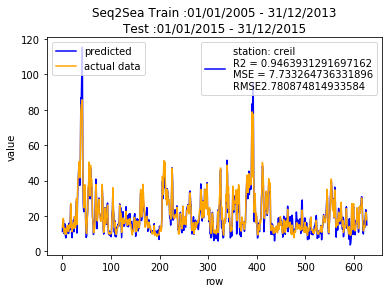

Root Mean Squared Error: 2.7809
Variance score: 0.946393
--------------------


In [42]:
for key in dict_data.keys():
    test_station(dict_data[key], key, False)
    print("--------------------")
